In [1]:
import numpy as np               
import matplotlib.pyplot as plt  
from rbvfit import model as m 
import dynesty

# Welcome back! At this point we should have all the tools and intro experience needed to try and sample a mock spectra with our new set of parameters and CLOUDY. I won't bore you so much with text on this one as I think reading / running the code will be more beneficial at this point

### Functions Needed

In [20]:
def frac_from_dens(redshift,density,temp,species,ion):  #useful code to produce ionization fraction
    
    cloudy = np.load('cloudy_table.npz')   #load table

    table = cloudy['table']
    #[redshift,density,temperature,species,ion]#
    
    rrange = np.arange(7,-1,-1) #redshift range from S Bird Cloudy tables
    trange = np.arange(3.,8.6,0.05) #temp range from S Bird Cloudy tables
    drange = np.arange(-7.,4.,0.2) #drange range from S Bird Cloudy tables
    
    spec = np.array(["H", "He", "C", "N", "O", "Ne", "Mg", "Si", "Fe"])
    
    trange = trange.round(3) #formatting necessary to read table

    r = np.where(rrange == redshift)
    t = np.where(trange == temp)
    el = np.where(spec == species)
    
    r = int(r[0])
    t = int(t[0])
    el = int(el[0])
    
    ion = ion-1 #account for formatting of np arrays
    
    frac = []
    for i in range (len(drange)):
        frac.append(table[r,i,t,el,ion])
    frac = np.array(frac)
    frac = 10**(frac)
    
    frac_dens = np.interp(density,drange,frac)
    
    return frac_dens

In [59]:
def gen_logN_arr(log_rho,log_los,log_temp,Met,elmnt,ion):
    N_tot = 10**(log_rho)*10**(log_los)
    log_temp = np.round(log_temp,1)
    f_solar_H = 1
    f_solar_He = 8.33*10**(-2)
    f_solar_C =  10**(-3.45)
    f_solar_N = 10**(-3.95)
    f_solar_O = 10**(-3.28)
    f_solar_Ne = 10**(-3.95)
    f_solar_Mg = 10. ** (-9.22)
    f_solar_Si = 3.24 * 10.**(-4.48)
    f_solar_Fe = 10.**(-4.53)
    
    logN_arr = []
    for i in range (len(elmnt)):
        N = 0
        
        if (elmnt[i] == 'H'):
            f_ion = f_solar_H
        elif (elmnt[i] == 'He'):
            f_ion = f_solar_He
        elif (elmnt[i] == 'C'):
            f_ion = f_solar_C
        elif (elmnt[i] == 'N'):
            f_ion = f_solar_N
        elif (elmnt[i] == 'O'):
            f_ion = f_solar_O
        elif (elmnt[i] == 'Ne'):
            f_ion = f_solar_Ne
        elif (elmnt[i] == 'Mg'):
            f_ion = f_solar_Mg
        elif (elmnt[i] == 'Si'):
            f_ion = f_solar_Si
        elif (elmnt[i] == 'Fe'):
            f_ion = f_solar_Fe
        else:
            continue
        for j in range (n_clouds):
            f = frac_from_dens(0,log_rho[j],log_temp[j],elmnt[i],ion[i]) * f_ion
            N += N_tot * f * Met
        lgN = np.log10(N)
        logN_arr.append(lgN)
    
    logN_arr = np.array(logN_arr)
    logN_arr = logN_arr.ravel() #makes array 1-D
    logN_arr = logN_arr.reshape(len(lambda_rest),n_clouds)
    return logN_arr

In [67]:
def compile_model(log_rho,log_los,v,log_temp,b,Met,elmnt,ion):
    
    logN_arr = gen_logN_arr(log_rho,log_los,log_temp,Met,elmnt,ion)
    outflx = []
    for i in range (len(lambda_rest)):
        for j in range (n_clouds):
            theta = np.array([logN_arr[i,j],b[j],v[j]])
            nclump = n_clouds
            s= m.create_voigt(zabs,[lambda_rest[i]],nclump,1,FWHM = '6.5',verbose=True)
            flx = s.model_flux(theta,wave)
            outflx.append(flx)
    tau = -np.log(outflx)
    op_depth_arr = np.sum(tau,axis =0)
    model = np.exp(-op_depth_arr)
    
    return model

### Parameter Set Up

In [97]:
n_clouds     = 1
log_rho      = np.array([1.2])     #total log density of cloud
Metallicity  = 0.7                 #total metallicity of cloud
log_los      = np.array([21.2])    #log of the length of the line of sight
log_temp     = np.array([4.2])     #log Temperature of cloud
b            = np.array([12.3])    #Doppler b of cloud
v            = np.array([100.])    #Velocity of cloud

lambda_rest  = np.array([1845.5202, 1526.7066,2026.4768,2796.352])  #rest wavelengths for SiI,SiII,MgI,MgII respectively
wave         = np.arange(1500,3000,0.01)  #wavelegnth range to encompass all rest wavelengths
f_solar_Mg   = 10. ** (-9.22)
f_solar_Si   = 3.24 * 10.**(-4.48)   #scaled solar abundances of Si, Mg 

In [81]:
total_N = 10**(log_rho) * 10**(log_los)

N_Si = total_N * Metallicity * f_solar_Si  #total SI column Density
N_Mg = total_N * Metallicity * f_solar_Mg  #total Mg column Density

In [82]:
redshift = np.array([0.0])  #necessary input parameter for CLOUDY 
zabs = redshift
density = np.array([np.log10(total_rho)]) #need log vals of Density and temp
temp = np.array([np.log10(T)])
species = np.array(['Si','Si','Mg','Mg'])
ion = np.array([1,2,1,2])   #Accounts for Si I,II and MgI,II

In [83]:
# Now lets find our indvidual column densities for all 4 of our species

f_Si_I = (frac_from_dens(redshift,density,temp,species[0],ion[0]))
f_Si_II = (frac_from_dens(redshift,density,temp,species[1],ion[1]))
f_Mg_I = (frac_from_dens(redshift,density,temp,species[2],ion[2]))
f_Mg_II = (frac_from_dens(redshift,density,temp,species[3],ion[3]))

In [84]:
N_Si_I      =  N_Si * f_Si_I   
N_Si_II     =  N_Si * f_Si_II
logN_Si_I   =  np.log10(N_Si_I)
logN_Si_II  =  np.log10(N_Si_II)

N_Mg_I      =  N_Mg * f_Mg_I
N_Mg_II     =  N_Mg * f_Mg_II
logN_Mg_I   =  np.log10(N_Mg_I)
logN_Mg_II  =  np.log10(N_Mg_II)

In [85]:
print("The log Column Density of Si-I is",logN_Si_I,"and Si-II is ",logN_Si_II)

The log Column Density of Si-I is [16.10264305] and Si-II is  [18.25164305]


In [86]:
print("The log Column Density of Mg-I is",logN_Mg_I,"and Mg-II is ",logN_Mg_II)

The log Column Density of Mg-I is [11.55609804] and Mg-II is  [12.89609804]


# Now we will use our Compile model function to create a flux file that has absorbers at the rest wavelengths for SiI/II and MgI/II and with their respective column density. Note they will all have the same b and v values because they are part of the same cloud.

In [87]:
#first lets make sure our logN_arr function works, we can see up above what our values should be
logN_array = gen_logN_arr(log_rho,log_los,log_temp,Metallicity,species,ion)
logN_array #should match up in order of Si I, Si II, Mg I, MgII

array([[16.10264305],
       [18.25164305],
       [11.55609804],
       [12.89609804]])

In [98]:
flux = compile_model(log_rho,log_los,v,log_temp,b,Metallicity,species,ion) + np.random.normal(0,0.06,len(wave))

Added line:SiI 1845 at z:0.0
Added line:SiII 1526 at z:0.0
Added line:MgI 2026 at z:0.0
Added line:MgII 2796 at z:0.0


/scratch/local/43399125/ipykernel_28354/1842053446.py:12: RuntimeWarning: divide by zero encountered in log
  tau = -np.log(outflx)


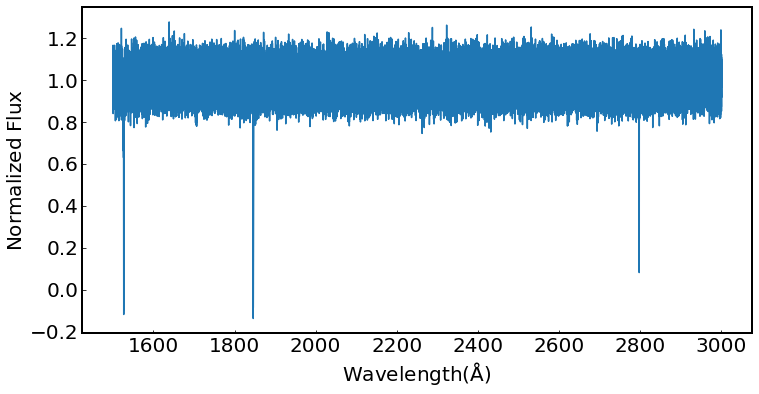

In [99]:
fig, ax = plt.subplots(figsize=(12, 6))
    
ax.plot(wave,flux,label='Mock Spectrum')
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)   

# So you should see some narrow lines at the rest wavelengths we specified, now lets instead use the doppler shift eqaution to convert the wavelength to a relative velocity and plot that
# This is a more conventional way to plot. 0 velocity here means absorption is happening right at the rest wavelength

In [100]:
# or plot this to zoom in 
c = 3*10**5  # speed of light in km/s

velo1 = c*(  (wave-lambda_rest[0]) / lambda_rest[0] )  #doppler equation  
velo2 = c*(  (wave-lambda_rest[1]) / lambda_rest[1] )  
velo3 = c*(  (wave-lambda_rest[2]) / lambda_rest[2] ) 
velo4 = c*(  (wave-lambda_rest[3]) / lambda_rest[3] ) 

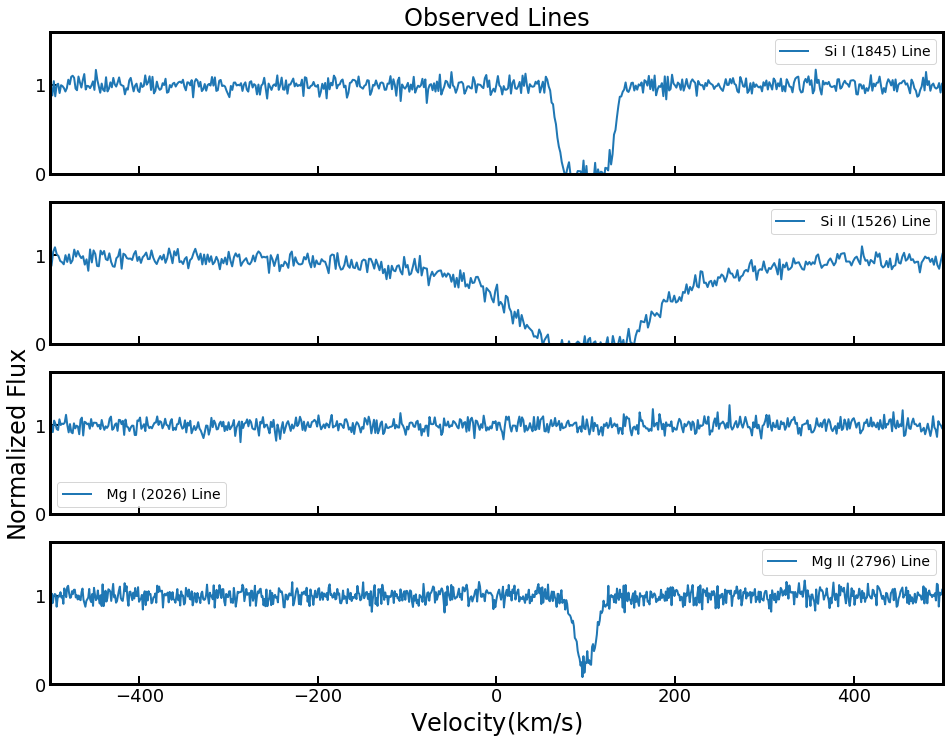

In [103]:
fig, (ax1, ax2,ax3,ax4) = plt.subplots(4, sharex=True,figsize= (16,12))

ax1.set_title("Observed Lines",fontsize = 24)
    

ax1.plot(velo1,flux, label=' Si I (1845) Line',linewidth=2)
ax2.plot(velo2,flux, label=' Si II (1526) Line',linewidth=2)
ax3.plot(velo3,flux, label=' Mg I (2026) Line',linewidth=2)
ax4.plot(velo4,flux, label=' Mg II (2796) Line',linewidth=2)

ax1.set_xlim(-500,500)

ax1.set_ylim(0,1.6)
ax2.set_ylim(0,1.6)
ax3.set_ylim(0,1.6)
ax4.set_ylim(0,1.6)

ax1.legend(fontsize='14')
ax2.legend(fontsize='14')
ax3.legend(fontsize='14',loc=3)
ax4.legend(fontsize='14')
ax3.set_ylabel(r'$\mathrm{Normalized\;Flux}$',fontsize=24)
ax4.set_xlabel(r'$\mathrm{Velocity (km/s)}$',fontsize=24)
ax1.xaxis.set_tick_params(direction='in',size=8,width=2)
ax1.yaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)
ax2.xaxis.set_tick_params(direction='in',size=8,width=2)
ax2.yaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)
ax3.xaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)
ax3.yaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)
ax4.xaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)
ax4.yaxis.set_tick_params(direction='in',labelsize = '18',size=8,width=2)

for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(3)
    ax2.spines[axis].set_linewidth(3)
    ax3.spines[axis].set_linewidth(3)
    ax4.spines[axis].set_linewidth(3)

# The biggest benefit of plotting flux vs velo is that you can vertically line up absorbers with the same velocity, see how each absorption in the 4 frames happens "on top" of each other. That's because they are in the same cloud! Note: box 3 should be a flat line (Mg I 2026)

In [105]:
len(flux) 
#this is a big number and will be computationally heavy when we want to sample, lets cut it and only include the regions where our absorbers are

150000

In [108]:
wave = np.concatenate((np.arange(1520.,1532.,.01),np.arange(1840.,1850.,.01),np.arange(2020.,2032.,.01),np.arange(2790,2802,0.01)))

In [109]:
flux = compile_model(log_rho,log_los,v,log_temp,b,Metallicity,species,ion) + np.random.normal(0,0.06,len(wave))

Added line:SiI 1845 at z:0.0
Added line:SiII 1526 at z:0.0
Added line:MgI 2026 at z:0.0
Added line:MgII 2796 at z:0.0


/scratch/local/43399125/ipykernel_28354/1842053446.py:12: RuntimeWarning: divide by zero encountered in log
  tau = -np.log(outflx)


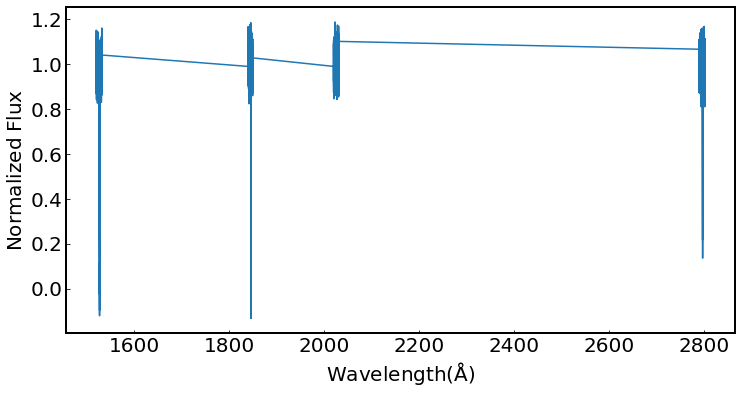

In [110]:
fig, ax = plt.subplots(figsize=(12, 6))
    
ax.plot(wave,flux,label='Mock Spectrum')
ax.set_ylabel(r'$\mathrm{Normalized\;Flux}$')
ax.set_xlabel(r'$\mathrm{Wavelength (\AA)}$')
ax.xaxis.set_tick_params(direction='in')
ax.yaxis.set_tick_params(direction='in')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)   

# This method can become tedious once we have a large number of rest wavelengths we wish to inspect.
# Now we want to sample this spectrum and see if we can return good estimates on all 6 parameters. However, we cannot do this in the Jupyter Notebook as it may take well over 24 hours to run. 
# Instead we turn our eyes to the beauty of SLURM jobs that can be sent to Hipergator. We can just let the sampling be run externally and not have to worry about it until it has finished. 
# Turn to slurm_sample.py and slurm_sample.sh and save our wavelength and flux files

In [ ]:
np.savetxt('flux_cloudy.csv',flux,delmiter=',')
np.savetxt('wave_cloudy.csv',wave,delmiter=',')